# Multi Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import numpy as np
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam

# numpyro.set_host_device_count(10)
# numpyro.enable_x64()
# numpyro.set_host_device_count(2)

Then, import the `MultiStarModel` from `celestify`.

In [2]:
from celestify.numpyro_models import MultiStarModel

2024-01-09 14:41:31.140775: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 14:41:31.140807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 14:41:31.141887: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 14:41:31.727933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [3]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook
num_stars = 100

rng, key = random.split(rng)
true_model = MultiStarModel(num_stars)

# This samples from the true model given some random key
true_trace = handlers.trace(
    handlers.seed(true_model, key)
).get_trace()
truths = {key: param["value"] for key, param in true_trace.items()}
pprint(truths)

2024-01-09 14:41:36.701354: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


{'M_H': Array([ 0.11284818,  0.17254141,  0.16214807, -0.58948225, -0.62612617,
       -0.08617996,  0.0499701 , -0.260563  , -0.35740608, -0.28829092,
       -0.30700487,  0.00304657, -0.04872356, -0.5088303 , -0.3773864 ,
       -0.8655448 , -0.29151592, -0.63752824,  0.43957874, -0.04633765,
       -0.35185665, -0.05104818,  0.4133148 , -0.6394218 , -0.8503055 ,
       -0.18449494, -0.20707646, -0.33725518,  0.01626354, -0.03597194,
        0.01134542,  0.19636515,  0.07599007, -0.55429184, -0.39275402,
       -0.07026671,  0.28367403,  0.2865619 , -0.7282802 ,  0.41588613,
       -0.34685495,  0.19896579, -0.45205873, -0.4161479 ,  0.3221398 ,
       -0.87827647, -0.25499013, -0.3280167 , -0.15791847,  0.11898141,
       -0.4777882 , -0.05296668, -0.46833387,  0.00838876, -0.5293081 ,
       -0.86998343, -0.6416079 ,  0.32310227, -0.5189499 , -0.08390775,
        0.3622066 , -0.43213356,  0.02599525,  0.4906243 ,  0.05208353,
        0.43086842, -0.25508538, -0.7682884 , -0.0526874

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [4]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=100.),
    "log_g": dict(scale=0.1),
}

# Create model
model = MultiStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': Array([ 0.31268466,  0.08366455,  0.19454096, -0.43550074, -0.63824666,
       -0.31475264, -0.05568356, -0.24743146, -0.26725802, -0.23947373,
       -0.33294332,  0.03831529, -0.17418413, -0.7034715 , -0.34973577,
       -0.955415  , -0.18591484, -0.6608324 ,  0.47828597, -0.02333019,
       -0.38825938,  0.08645883,  0.49790198, -0.61723596, -0.85815024,
       -0.23488513, -0.24693912, -0.20156163, -0.08086048, -0.07543159,
        0.10725149,  0.38039845,  0.0598299 , -0.64337033, -0.44256854,
       -0.11953087,  0.34120858,  0.13565491, -0.5609757 ,  0.3926533 ,
       -0.35524783,  0.03448226, -0.482305  , -0.48614702,  0.4855733 ,
       -0.9257807 , -0.30561486, -0.26424974, -0.06659915, -0.02053503,
       -0.5334548 , -0.21527632, -0.62787145,  0.02256061, -0.40540937,
       -0.89372563, -0.67569184,  0.28210846, -0.50893325, -0.08246385,
        0.3695976 , -0.5219738 ,  0.0331229 ,  0.45850497,  0.14080182,
        0.45059216, -0.1654553 , -0.6684906 ,  0

## Prior Predictive

Sample from the model prior.

In [5]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=2000)
prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [6]:
coords = {"star": np.arange(num_stars)}
dims = {key: ["star"] for key, value in prior_samples.items() if value.ndim > 1}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

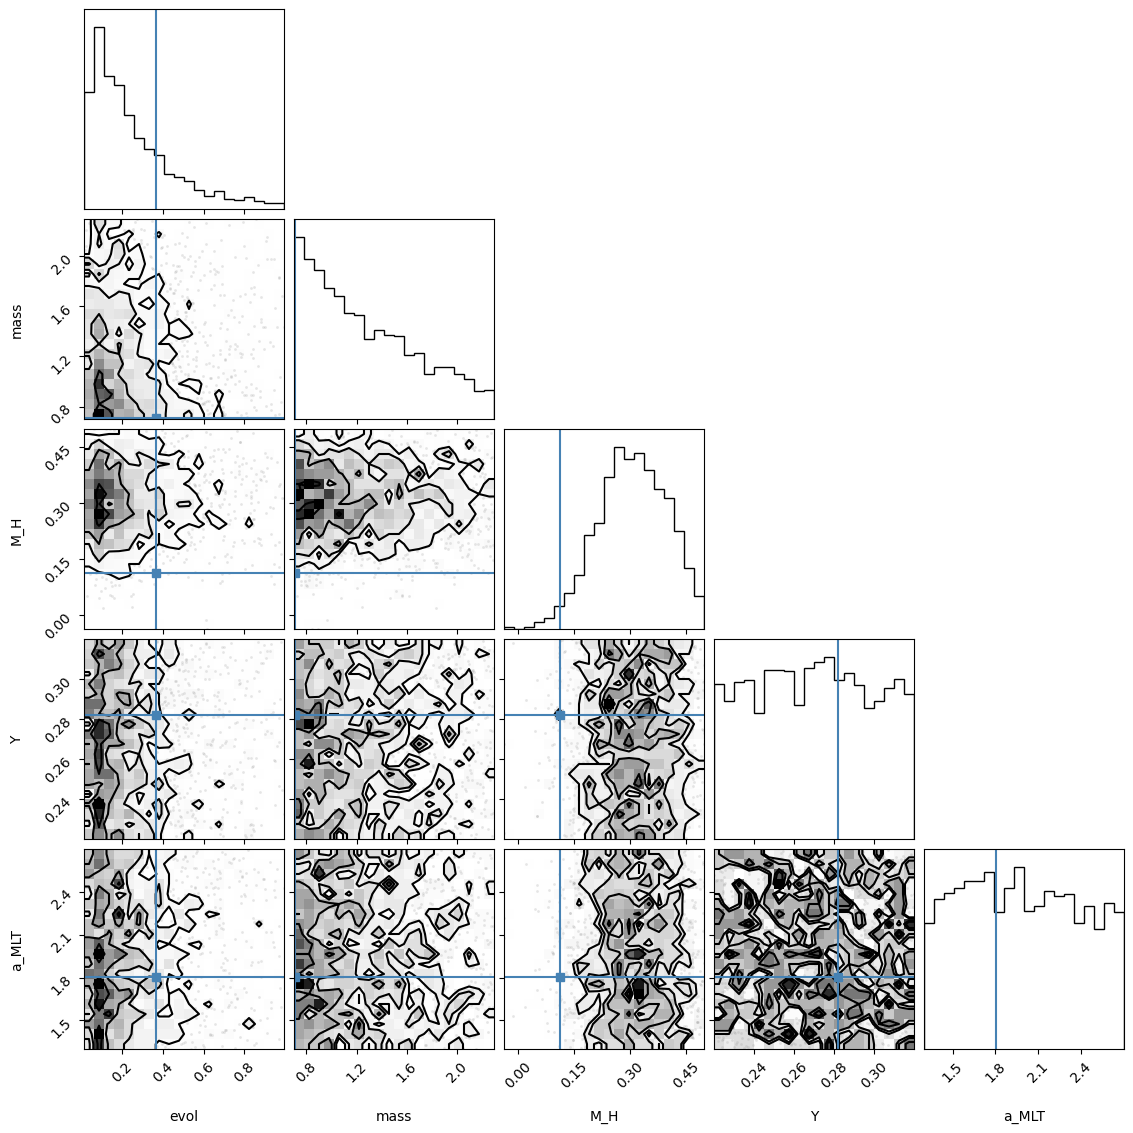

In [7]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

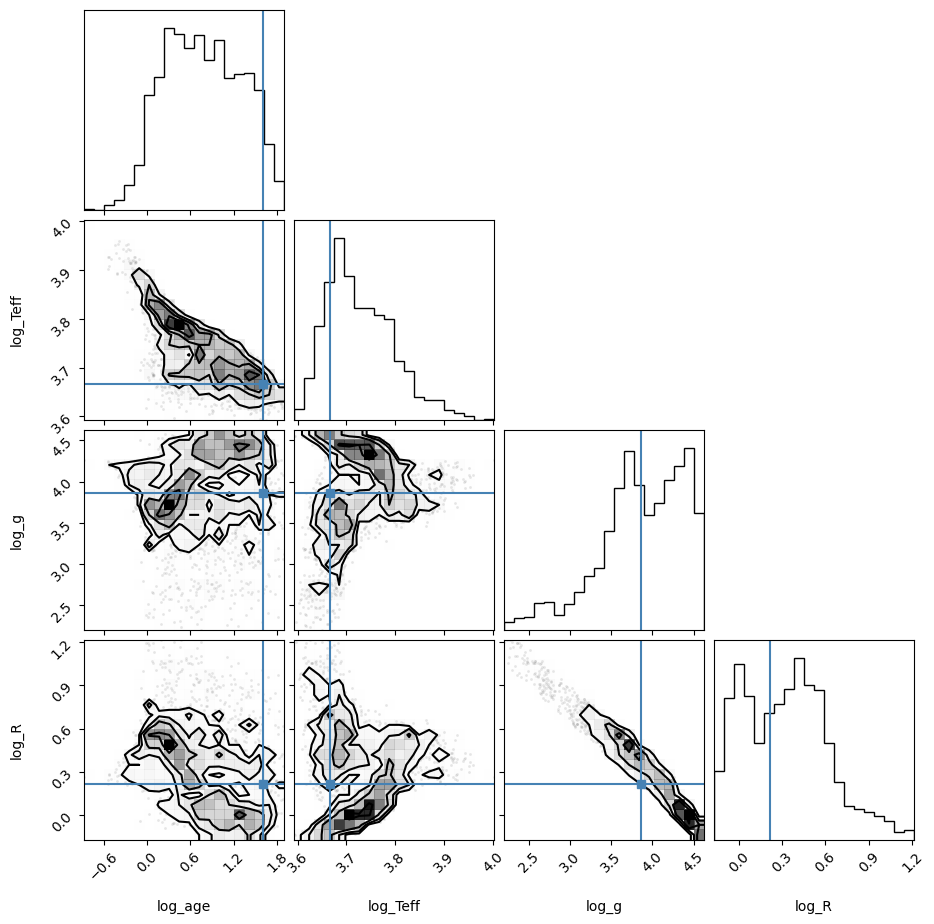

In [8]:
star = 0
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

## Observation

Now we synthesize observable parameters for the model.

In [9]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
}
pprint(obs)

{'Teff': Array([ 4662.3813,  5319.1055,  6691.3965,  5777.403 ,  4963.023 ,
        4660.321 ,  5571.132 ,  5699.386 ,  5937.9727,  5491.069 ,
        5183.2715,  9385.487 ,  4815.3623,  8659.342 ,  7739.9775,
        9537.055 ,  6642.407 ,  5043.331 ,  4938.479 ,  5311.223 ,
        5951.396 ,  5939.971 ,  4153.384 , 10629.189 ,  5398.1743,
        5161.6963,  5935.52  ,  5162.3657,  5750.139 ,  6980.804 ,
        5963.3716,  5172.758 ,  4545.265 ,  6397.4824,  5359.782 ,
        7137.2085,  4328.5054,  4970.3115,  7538.086 ,  5200.8125,
        6128.697 ,  4862.3965,  5204.8896,  7009.558 ,  6034.569 ,
        8820.459 ,  5836.2637,  5896.4536,  5602.3164,  7802.81  ,
        5115.9136,  5234.1567,  6595.469 ,  5231.5596,  8514.798 ,
       12142.045 ,  6085.994 ,  5498.2764,  6094.904 ,  5740.406 ,
        6450.48  ,  7545.4443,  5795.656 ,  4745.947 ,  4492.4565,
        5464.6963,  5008.2197,  6852.904 ,  6037.125 ,  4671.788 ,
        6921.2373,  5468.83  ,  4679.6177,  4800.895 

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [10]:
sampler = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)

Let's run the MCMC and print a summary of results.

In [11]:
rng, key = random.split(rng)
mcmc.run(key, obs=obs)
mcmc.print_summary()

sample: 100%|██████████████████████████| 2000/2000 [10:55<00:00,  3.05it/s, 1023 steps of size 2.58e-03. acc. prob=0.83]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      M_H[0]      0.32      0.09      0.33      0.19      0.48    452.44      1.00
      M_H[1]      0.08      0.10      0.09     -0.08      0.24    451.32      1.00
      M_H[2]      0.16      0.10      0.16     -0.00      0.33    213.24      1.01
      M_H[3]     -0.44      0.11     -0.44     -0.61     -0.27    323.90      1.01
      M_H[4]     -0.64      0.09     -0.64     -0.78     -0.48    615.78      1.00
      M_H[5]     -0.28      0.10     -0.27     -0.43     -0.12    451.15      1.00
      M_H[6]     -0.05      0.10     -0.05     -0.23      0.10    359.60      1.00
      M_H[7]     -0.25      0.10     -0.25     -0.43     -0.10    429.21      1.00
      M_H[8]     -0.26      0.10     -0.27     -0.44     -0.12    267.90      1.00
      M_H[9]     -0.21      0.09     -0.20     -0.35     -0.05    440.71      1.00
     M_H[10]     -0.34      0.10     -0.34     -0.50     -0.19    502.01      1.00
   

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [12]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

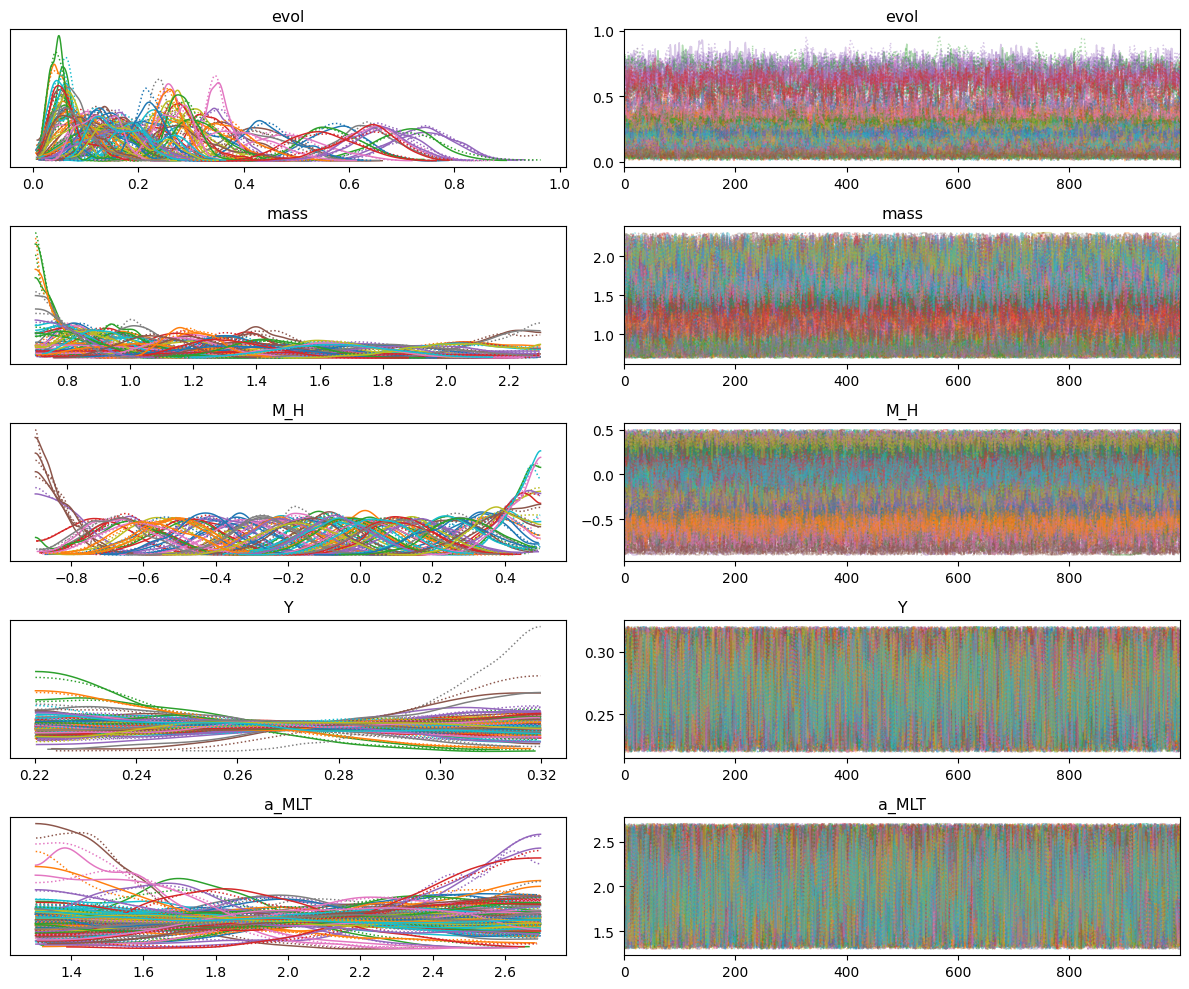

In [13]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

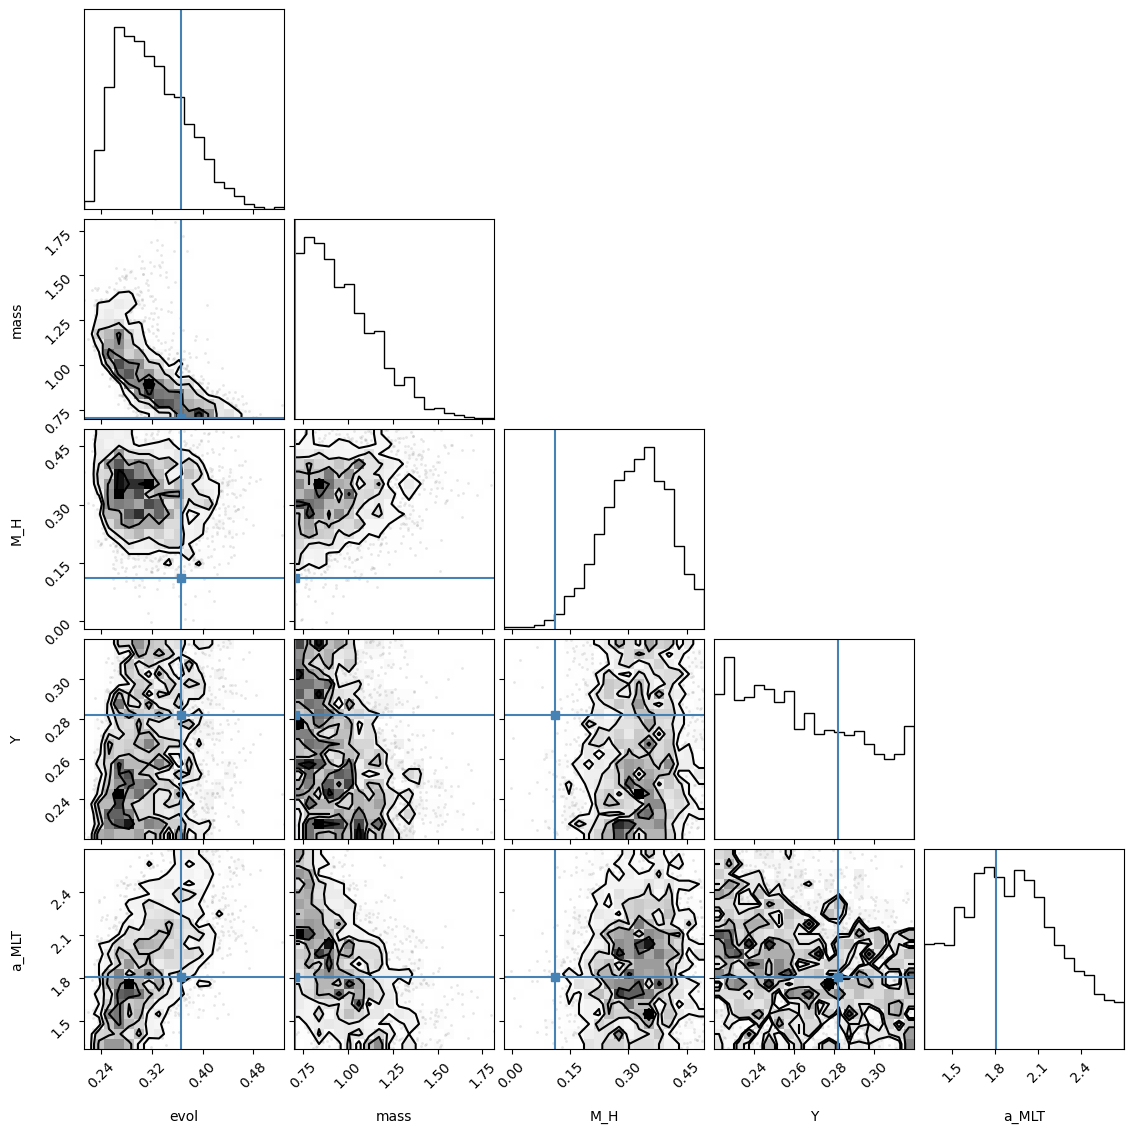

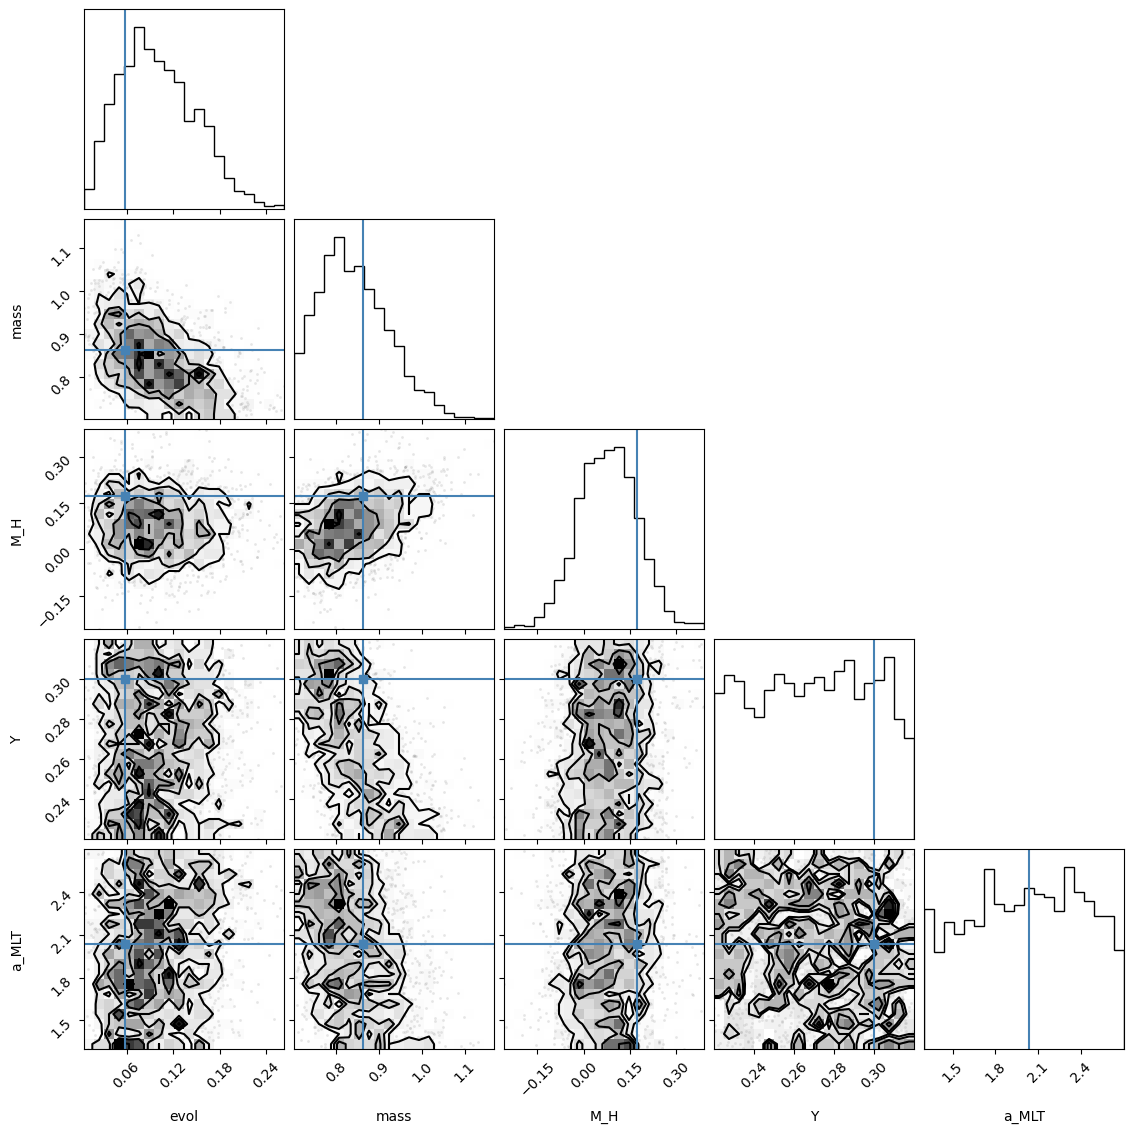

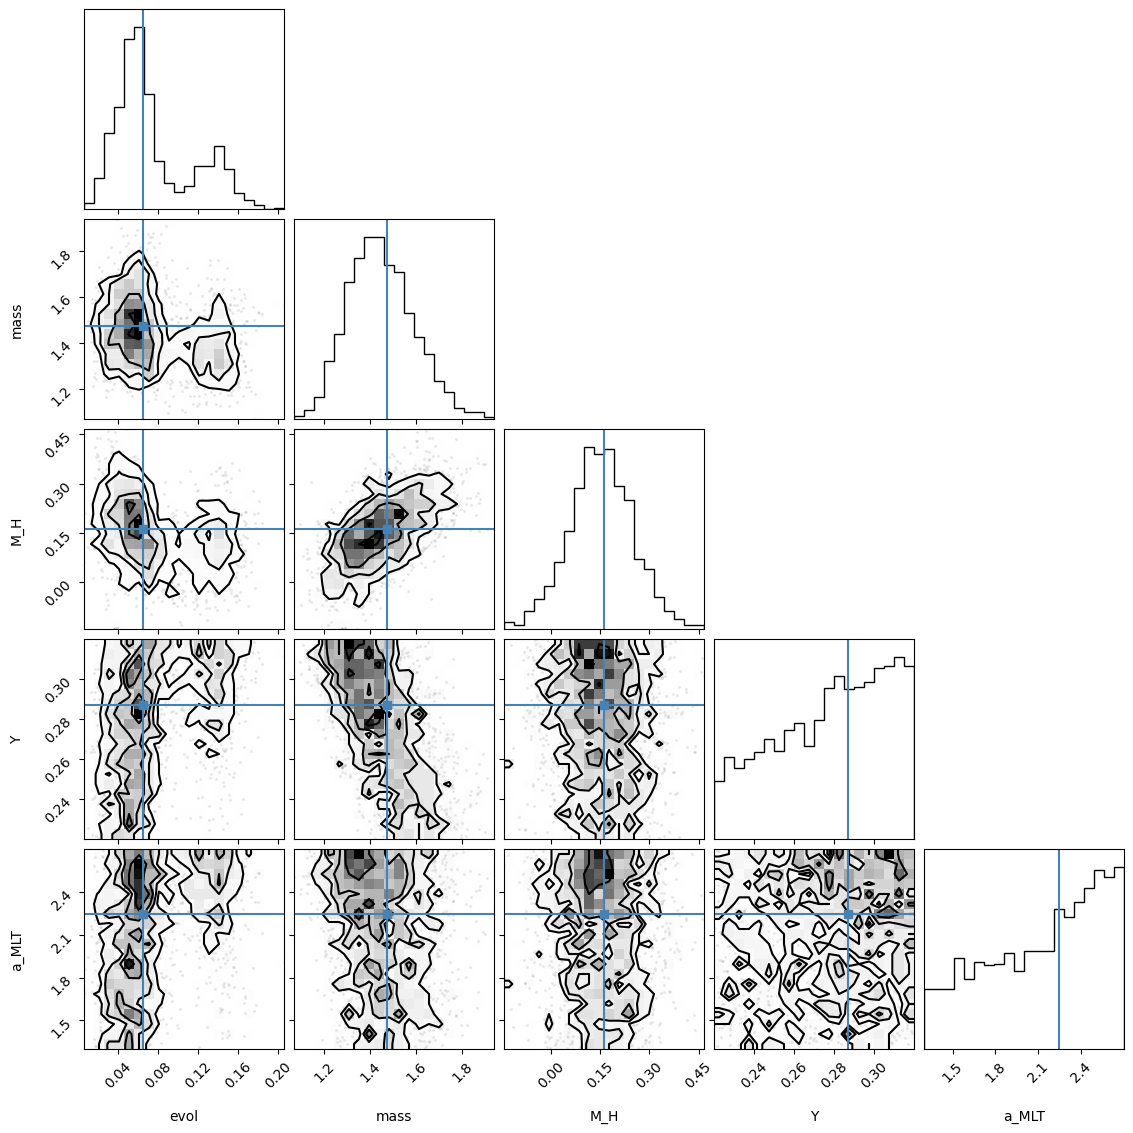

In [14]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

What do we predict for some deterministics?

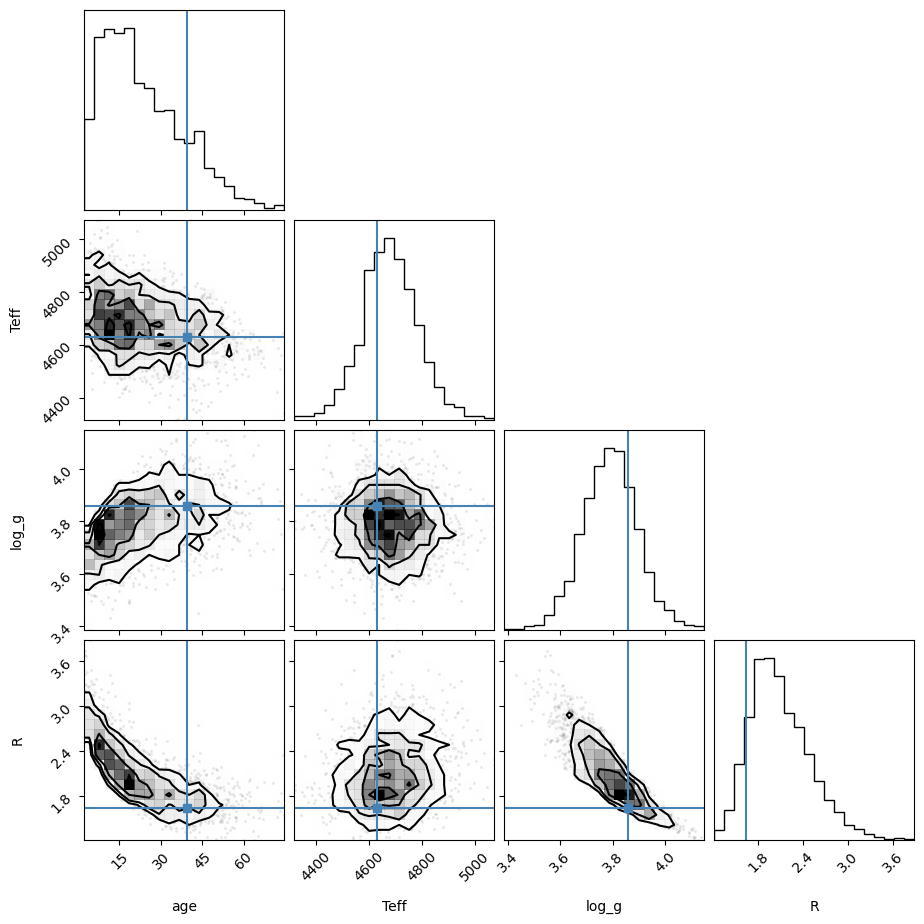

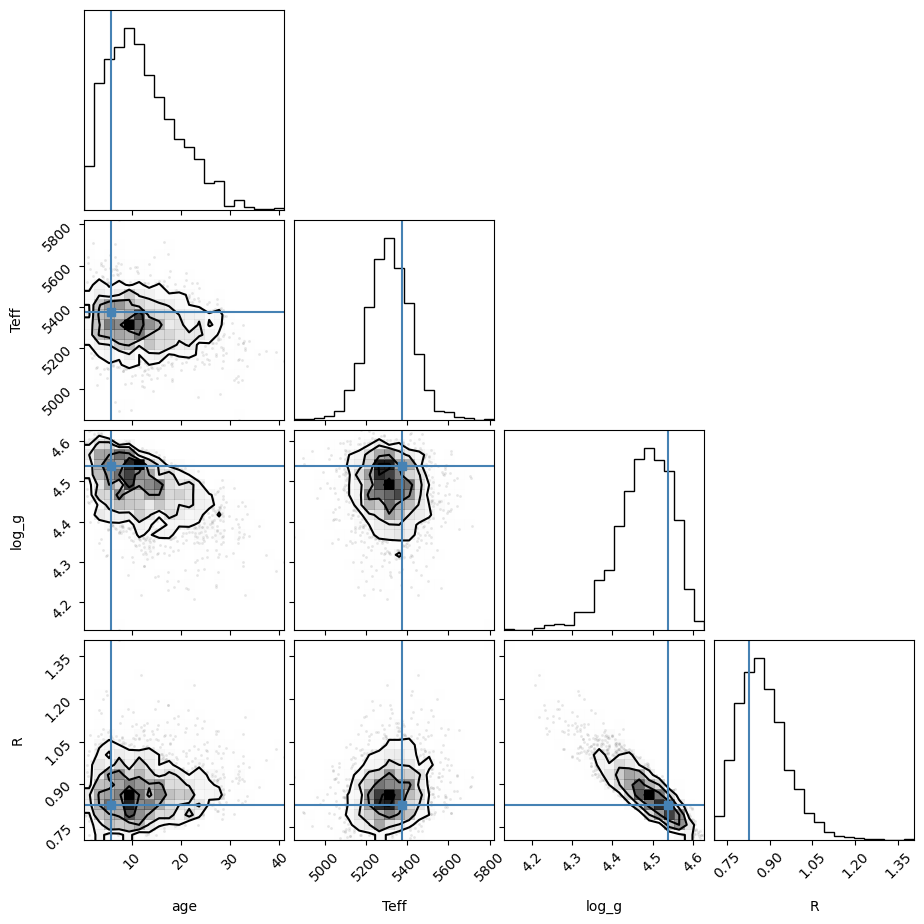

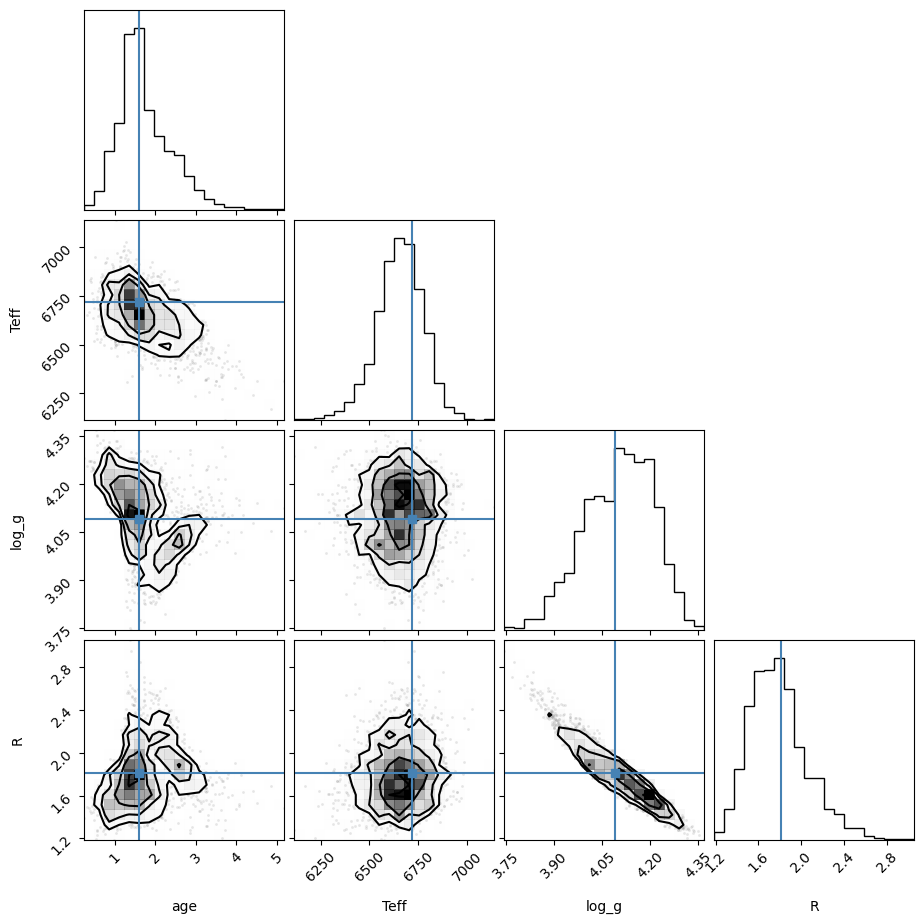

In [15]:
var_names = ["age", "Teff", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [17]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]   -0.205  0.086  -0.360   -0.046      0.003    0.002     797.0   
M_H[1]    0.094  0.096  -0.087    0.269      0.003    0.002     847.0   
M_H[2]    0.010  0.097  -0.183    0.188      0.004    0.003     474.0   
M_H[3]   -0.158  0.097  -0.339    0.032      0.003    0.002     780.0   
M_H[4]    0.016  0.098  -0.158    0.214      0.004    0.003     651.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[95] -0.071  0.104  -0.274    0.112      0.004    0.003     547.0   
mass[96] -0.368  0.165  -0.675   -0.058      0.008    0.006     466.0   
mass[97]  0.028  0.057  -0.071    0.108      0.002    0.002     529.0   
mass[98]  0.263  0.164  -0.015    0.549      0.009    0.006     250.0   
mass[99] -0.045  0.180  -0.405    0.270      0.012    0.008     244.0   

          ess_tail  r_hat  
M_H[0]       514.0   1.00  
M_H[1]       785.0   1.00  
M_H[2]       428.0   1.00  
M_H[3]       852.0   1.00  
M_H[4]       286.0   1.00  
...            ...    ...  
mass[95]     758.0   1.00  
mass[96]     408.0   1.01  
mass[97]     632.0   1.00  
mass[98]     142.0   1.00  
mass[99]     429.0   1.01  

[1600 rows x 9 columns]

In [18]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]   -1.820  0.762  -3.194   -0.405      0.025    0.021     797.0   
M_H[1]    0.546  0.555  -0.502    1.556      0.019    0.014     847.0   
M_H[2]    0.063  0.598  -1.129    1.160      0.028    0.019     474.0   
M_H[3]    0.268  0.165  -0.055    0.575      0.006    0.004     780.0   
M_H[4]   -0.025  0.156  -0.342    0.252      0.006    0.005     651.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[95] -0.071  0.104  -0.273    0.111      0.004    0.003     547.0   
mass[96] -0.289  0.130  -0.530   -0.046      0.006    0.005     466.0   
mass[97]  0.034  0.071  -0.088    0.134      0.003    0.002     529.0   
mass[98]  0.115  0.072  -0.006    0.240      0.004    0.003     250.0   
mass[99] -0.028  0.112  -0.252    0.168      0.007    0.005     244.0   

          ess_tail  r_hat  
M_H[0]       514.0   1.00  
M_H[1]       785.0   1.00  
M_H[2]       428.0   1.00  
M_H[3]       852.0   1.00  
M_H[4]       286.0   1.00  
...            ...    ...  
mass[95]     758.0   1.00  
mass[96]     408.0   1.01  
mass[97]     632.0   1.00  
mass[98]     142.0   1.00  
mass[99]     429.0   1.01  

[1600 rows x 9 columns]

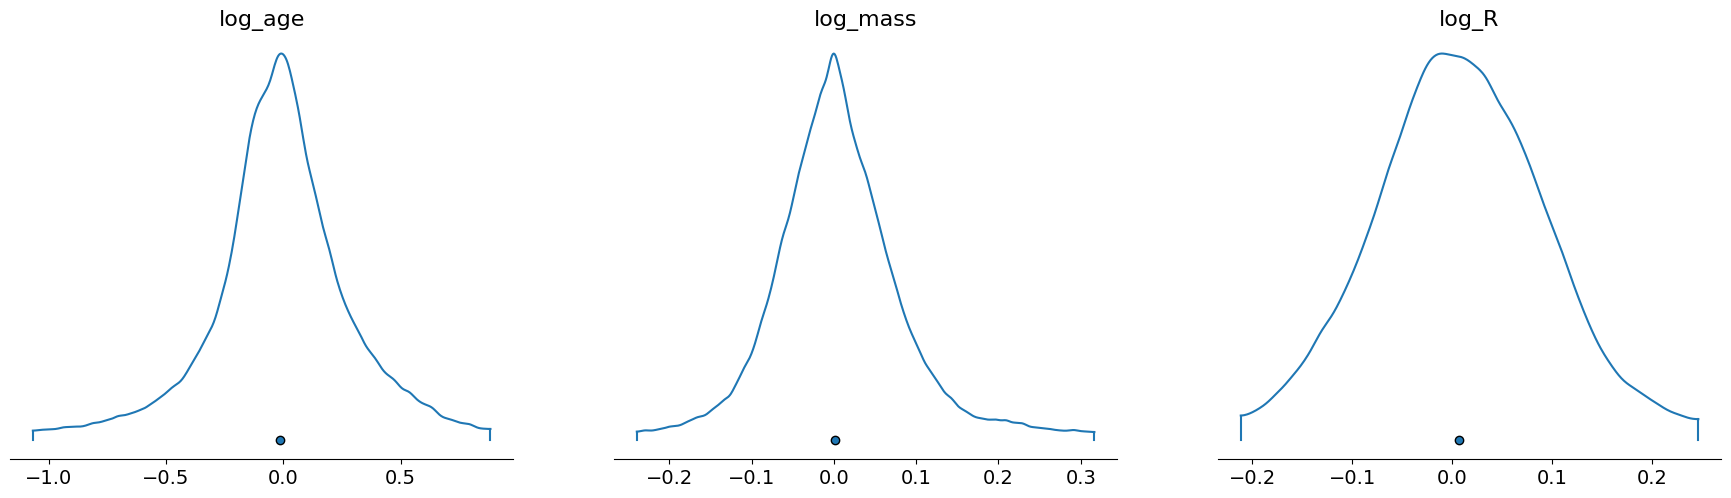

In [19]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

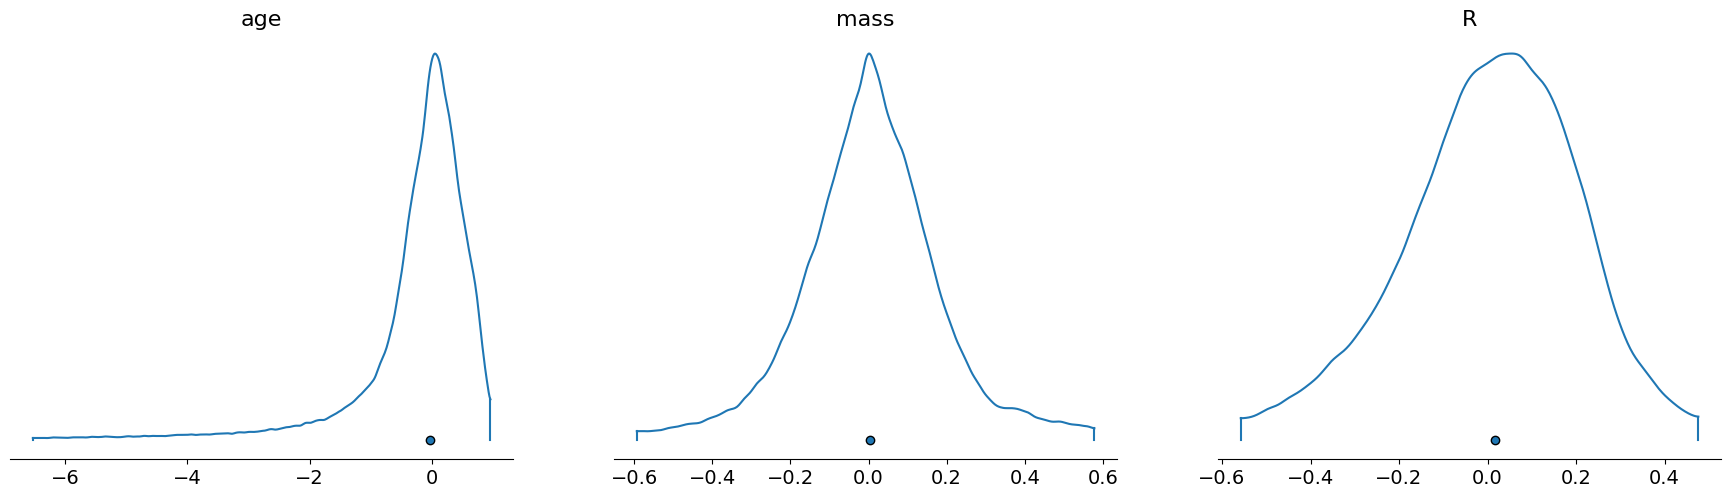

In [20]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

In [47]:
x = data.posterior[["mass", "a_MLT"]].to_array().values.reshape((2, 2000, 100))

In [53]:
import jax.numpy as jnp
from jax import vmap

In [60]:
corr = vmap(jnp.corrcoef, -1, -1)(x) 
std = vmap(jnp.std, (-1, None), -1)(x, 1)

So if you change the MLT by 0.1 you change the mass by - 0.15

In [67]:
sa_sm = np.divide(*std[:, ::-1])
dm_da = sa_sm * corr[0, 1]


In [73]:
da = 0.1


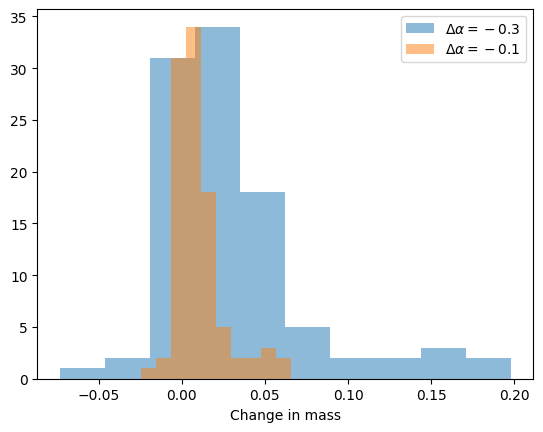

In [81]:
fig, ax = plt.subplots()

for da in [-0.3, -0.1]:
    dm = da * dm_da
    ax.hist(dm, alpha=0.5, label=f"$\\Delta\\alpha = {da}$")
ax.set_xlabel("Change in mass")
ax.legend()